In [37]:
import sys

import datasets

if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Installing requisite packages
    !pip install datasets transformers evaluate
    !pip install accelerate -U

    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')

    # Change working directory to ex1
    %cd /content/drive/MyDrive/LLM4behavior_workshop/ex1

## Loading data

In [38]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset

In [39]:
# Reading in the .csv data
dat = pd.read_csv('health.csv')
dat 

,text,labels
0,Broken leg. A broken leg (leg fracture) will b...,49.333333
1,Bulimia. Bulimia is an eating disorder and men...,34.181818
2,Hyperacusis. Hyperacusis is when everyday soun...,53.818182
3,DVT. DVT (deep vein thrombosis) is a blood clo...,12.800000
4,Ectopic pregnancy. An ectopic pregnancy is whe...,31.700000
...,...,...
772,Typhoid fever. Typhoid fever is a bacterial in...,27.900000
773,Ankylosing spondylitis. Ankylosing spondylitis...,30.800000
774,Sleepwalking. Sleepwalking is when someone wal...,71.181818
775,Fits. If you see someone having a seizure or f...,34.111111


In [40]:
# Converting to Dataset
dat = Dataset.from_pandas(dat)
dat

Dataset({
    features: ['text', 'labels'],
    num_rows: 777
})

## Feature extraction

In [41]:
from transformers import pipeline, AutoModel
import torch

In [42]:
# Loading the model and moving it to the GPU if available
if torch.cuda.is_available():  # for nvidia GPUs
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # for Apple Metal Performance Sharder (mps) GPUs
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='mps')

At the time of writing, ember-v1 was top of the sequence classificaiotn leaderboard: https://huggingface.co/spaces/mteb/leaderboard

In [43]:
def extract_features(text: Dataset, model_ckpt: str):
    """Extracts features from text using a pretrained model."""
    pipe = pipeline(
        'feature-extraction', model=model_ckpt, device=device,
        tokenizer=model_ckpt, framework='pt', batch_size=16
    )
    pipe_iterator = pipe(
        KeyDataset(text, 'text'), return_tensors='pt',
        tokenize_kwargs= {'padding': True, 'truncation': True}
    )
    
    features = []
    for out in tqdm(pipe_iterator, total=len(text)):
        # Extracting features for the first token (CLS token)
        features.append(out[0, 0, :].numpy())

    return np.array(features, dtype=float)


ember_features = extract_features(dat, 'llmrails/ember-v1')
ember_features

  0%|          | 0/777 [00:00<?, ?it/s]

array([[-0.08294404, -0.12866203, -0.60454446, ...,  0.19957913,
         1.15794826, -0.56118006],
       [-0.31066939, -0.24826328, -0.20578656, ...,  0.15426728,
         0.13788129, -0.58978915],
       [-0.17138763,  0.18544668, -0.66520971, ...,  0.6714049 ,
        -0.46794409, -0.74806696],
       ...,
       [-0.06886026,  1.00021124, -1.13028955, ..., -0.08054055,
         0.34994519,  0.41196632],
       [ 0.44230643,  0.75519091, -0.4424752 , ..., -0.27366173,
         0.7625562 , -0.71330738],
       [-0.28059521, -0.28387243, -0.03451121, ..., -0.10158359,
        -0.17323664, -0.37684989]])

# Cross-validation

In [44]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [45]:
distilbert_features = pd.read_csv('distilbert_features.csv')
distilbert_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.148475,-0.093959,-0.072606,-0.116719,-0.197698,-0.017892,0.583106,0.199220,-0.294927,-0.524650,...,0.132813,-0.284638,0.341142,-0.053502,0.222674,0.264824,-0.127856,0.016527,-0.165402,0.297364
1,-0.188410,-0.126732,-0.108507,-0.293917,-0.218685,0.010479,0.353766,0.414596,-0.126797,-0.443795,...,-0.127295,-0.445322,0.027356,-0.416753,-0.055470,0.358791,-0.196915,-0.088872,-0.025871,0.366596
2,-0.171668,-0.050836,-0.194084,-0.312468,-0.174100,-0.011414,0.494835,0.385607,-0.115327,-0.769145,...,0.038155,-0.398147,0.033521,-0.147881,0.203515,0.511178,-0.293286,-0.232812,-0.022038,0.263111
3,-0.338618,-0.057856,0.033038,-0.357180,-0.202168,0.036766,0.324142,0.252396,-0.024016,-0.509216,...,0.136020,-0.368171,0.198924,-0.247393,0.010923,0.367897,-0.227437,-0.007300,0.000287,0.664291
4,-0.098636,-0.401457,-0.182545,-0.179665,0.064003,0.001181,0.291596,0.541527,-0.020205,-0.360373,...,-0.063380,-0.327838,0.088122,-0.291927,-0.019845,0.092592,0.024323,-0.213633,0.043224,0.738061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,-0.062923,-0.015915,-0.222807,-0.208136,-0.150941,-0.284561,0.377012,0.315895,-0.106533,-0.588245,...,0.030073,-0.439836,0.044907,-0.227704,-0.230707,0.228135,-0.225799,0.025129,0.063843,0.814006
773,-0.279977,-0.197014,0.098390,-0.303245,-0.296704,0.008300,0.288116,0.194376,-0.128856,-0.353388,...,-0.026887,-0.458937,0.206063,-0.471932,0.051058,0.154827,-0.420223,0.196191,0.028353,0.592685
774,-0.073572,-0.369269,0.076614,-0.097476,-0.064454,-0.054622,0.647633,0.325533,-0.363346,-0.434460,...,-0.008730,-0.349660,0.011828,-0.398827,-0.018842,0.212129,0.035592,-0.216679,-0.086199,0.413299
775,-0.181972,-0.083371,0.113803,-0.065226,0.033920,-0.130653,0.366495,0.114534,-0.174858,-0.477767,...,-0.016639,-0.359916,0.018970,-0.175317,0.033933,0.393584,-0.225063,-0.109431,0.165128,0.303420


In [46]:
mods = {'DistilBERT': distilbert_features, 'ember-v1': ember_features}
ridge = RidgeCV()
boost = GradientBoostingRegressor()
results = []

# Ridge
for mod_name, features in tqdm(mods.items(), desc='Ridge'):
    scores = cross_val_score(ridge, features, dat['labels'], cv=10, n_jobs=-1)
    results += [[mod_name, 'Ridge Regression', score] for score in scores]
    
# Gradient Boosting
for mod_name, features in tqdm(mods.items(), desc='Gradient Boosting'):
    scores = cross_val_score(boost, features, dat['labels'], cv=10, n_jobs=-1)
    results += [[mod_name, 'Gradient Boosting', score] for score in scores]

results = pd.DataFrame(results, columns=['model', 'estimator', 'score'])
results

Ridge:   0%|          | 0/2 [00:00<?, ?it/s]

Gradient Boosting:   0%|          | 0/2 [00:00<?, ?it/s]

,model,estimator,score
0,DistilBERT,Ridge Regression,0.619051
1,DistilBERT,Ridge Regression,0.618614
2,DistilBERT,Ridge Regression,0.497236
3,DistilBERT,Ridge Regression,0.612002
4,DistilBERT,Ridge Regression,0.610234
5,DistilBERT,Ridge Regression,0.630104
6,DistilBERT,Ridge Regression,0.679827
7,DistilBERT,Ridge Regression,0.559536
8,DistilBERT,Ridge Regression,0.494180
9,DistilBERT,Ridge Regression,0.510565


In [62]:
distilbert_mean = results.query(
    'model == "DistilBERT" & estimator=="Ridge Regression"'
)['score'].mean()
ember_mean = results.query(
    'model == "ember-v1" & estimator=="Gradient Boosting"'
)['score'].mean()

print(f'DistilBERT best mean R2: {distilbert_mean} \nember-v1 best mean R2: {ember_mean}')

DistilBERT best mean R2: 0.5831348904321467 
ember-v1 best mean R2: 0.5889249832790857


In [47]:
distilbert_preds = cross_val_predict(ridge, distilbert_features, dat['labels'], cv=10, n_jobs=-1)
preds = pd.DataFrame({'observed': dat['labels'], 'predicted': distilbert_preds})
preds

,observed,predicted
0,49.333333,56.729607
1,34.181818,48.833562
2,53.818182,58.280740
3,12.800000,36.298248
4,31.700000,51.495077
...,...,...
772,27.900000,33.559829
773,30.800000,47.163604
774,71.181818,65.222879
775,34.111111,40.929050


## Plotting

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_25650/544288786.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_25650/544288786.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


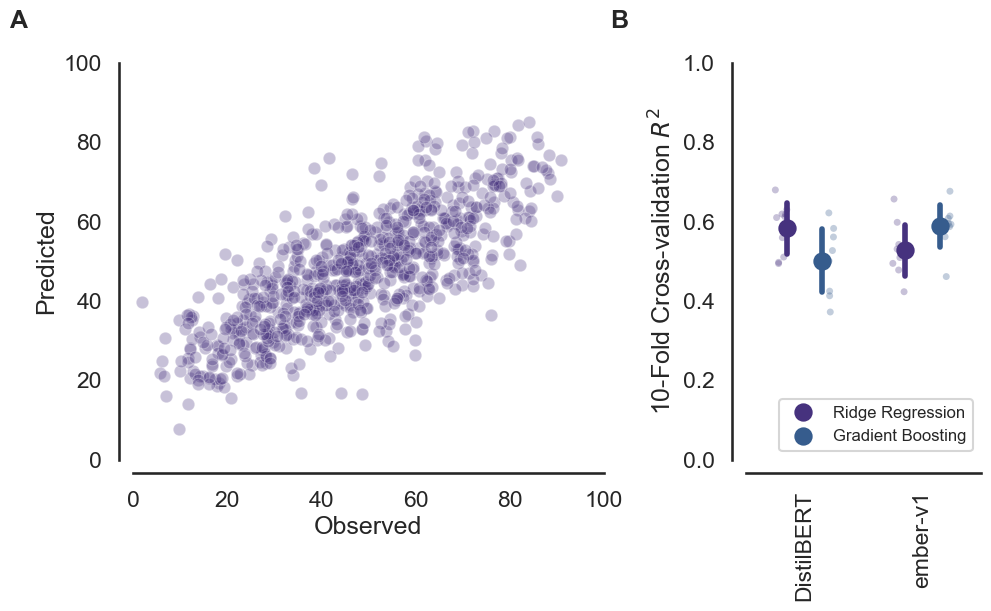

In [59]:
sns.set(context='talk', style='white', palette='viridis')
fig, axs = plt.subplots(1, 2, figsize=(10, 6), width_ratios=(1, .5))

# Panel A: Predicted vs. observed scatterplot
sns.scatterplot(preds, x='observed', y='predicted', alpha=.3, ax=axs[0])
axs[0].set(xlabel='Observed', ylabel='Predicted', ylim=(0, 100), xlim=(0, 100))

# Panel B: distilbert vs BGE 
sns.stripplot(
    results, x='model', y='score', hue='estimator', alpha=.3, legend=False, dodge=.3,
    ax=axs[1]
)

sns.pointplot(
    results, x='model', y='score', hue='estimator', errorbar='sd', zorder=1,
    join=False, dodge=.3, ax=axs[1])

axs[1].set(xlabel='', ylabel='10-Fold Cross-validation $R^2$', ylim=(0, 1))

# gets rid of legend title
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(title=None, fontsize=12, loc='lower right')

sns.despine(offset=10)

# rotate xticks 90 degres
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

#  Adds Panel Labels 
fontdict = {'fontsize':18, 'fontweight':'bold', 'va':'top', 'ha':'right'}
fig.text(0.02, 1.03, 'A', fontdict=fontdict)
fig.text(.62, 1.03, 'B', fontdict=fontdict)

plt.tight_layout()
plt.savefig('health.png', dpi=300, bbox_inches='tight')